In [1]:
import pandas as pd
import csv
from sklearn.model_selection import train_test_split

#Read the datasets
train_df = pd.read_csv("/kaggle/input/ys19-2023-assignment-2/train_set.csv")
val_df = pd.read_csv("/kaggle/input/ys19-2023-assignment-2/valid_set.csv")

#Concatenate train_df and val_df since they are the only ones that have a label and later split into train,validation and test set
#80% for training,10% validation,10% test
df = pd.concat([train_df, val_df], ignore_index=True)
#Remove rows that don't have acceptable values and seperate labels from data
acceptable_labels = ['POSITIVE','NEGATIVE','NEUTRAL']
df = df[df['Sentiment'].isin(acceptable_labels)]
labels = df['Sentiment']
original_df = df.drop('Sentiment', axis=1)

Import Libraries & Install Packages & Initialize Structures for Preprocessing:

In [2]:
%pip install demoji
%pip install emoji
%pip install emot
%pip install googletrans==4.0.0-rc1
%pip install Unidecode
%pip install greek-stemmer-pos
%pip install spacy 
!pip install torch
!pip install optuna
%pip install torchmetrics
from sklearn.metrics import f1_score, confusion_matrix
!python -m spacy download el_core_news_sm
import torch
import optuna
import spacy
import nltk
import re
import string
import emoji
import demoji
import emot
import itertools
import gensim
import multiprocessing
import numpy as np
import unicodedata as ud
import random
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.base import BaseEstimator, TransformerMixin
from googletrans import Translator
from emot.emo_unicode import EMOTICONS_EMO
from flashtext import KeywordProcessor
from sklearn.linear_model import LogisticRegression
from greek_stemmer import stemmer
from spacy.lang.el.examples import sentences 
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import word_tokenize

nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... - \ | done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.0 MB/s eta 0:00:00
  Created wheel for googletra

True

In [3]:
#Creating a simple function to roughly convert most greeklish to greek
greek_alphabet = 'ΑαΒβΓγΔδΕεΖζΗηΘθΙιΚκΛλΜμΝνΞξΟοΠπΡρΣσςΤτΥυΦφΧχΨψΩω'
latin_alphabet = 'AaBbGgDdEeZzHhJjIiKkLlMmNnXxOoPpRrSssTtUuFfQqYyWw'
greeklish_to_greek = str.maketrans(latin_alphabet,greek_alphabet)

#Creating a Keyword Processor for converting emojis and emoticons to their greek meaning
translator = Translator()
emoticons = {**EMOTICONS_EMO}
kp_emojis = KeywordProcessor()
#We will create a dictionary that maps each emoticon in each equivalent greek word. We will repeat the same for emojis
for emoticon,value in emoticons.items() :
    try :
       greek_value = translator.translate(value.replace(":","").replace("_"," ").strip(), src='en', dest='el').text
    except :
        greek_value = ""
        
    kp_emojis.add_keyword(emoticon, greek_value)
    
# Load the Greek language model for spacy
nlp = spacy.load('el_core_news_sm')

#More Greek stopwords from our custom made file
with open('/kaggle/input/lowercasegreekstopwords/Greek-Stopwords.txt', 'r') as file:
    # Read lines and remove '\n' from each line
    more_stopwords = [line.strip() for line in file.readlines()]
    
stops = set(stopwords.words('greek')).union(more_stopwords)

Data Preprocessing & Word Embeddings Using Word2Vec:

In [4]:
class DataPreprocessing(BaseEstimator, TransformerMixin):
    
    def remove_tags(self, text):
        return re.sub('@.*? ', '',text)
    
    def remove_urls(self, text):
        return re.sub(r'http.?://[^\s]+[\s]?', '',text)
    
    def emoji_to_word(self, text):
        #Get the map of emojis and their meaning in current text
        emojis = demoji.findall(text)
        #Convert the meaning to greek and add pair to keyword processor if it doesn't already exists
        for emoji,value in emojis.items():
            try :
               greek_value = translator.translate(value.replace(":","").replace("_"," ").strip(), src='en', dest='el').text
            except :
                greek_value = ""  
                
            # We replace emojis and emoticons with their corresponding greek words
            kp_emojis.add_keyword(emoji, greek_value) 
            
        return kp_emojis.replace_keywords(text)
    def remove_emoji(self, text):
        emoji_pattern = re.compile("["
                               u"U0001F600-U0001F64F"  # emoticons
                               u"U0001F300-U0001F5FF"  # symbols & pictographs
                               u"U0001F680-U0001F6FF"  # transport & map symbols
                               u"U0001F1E0-U0001F1FF"  # flags (iOS)
                               u"U00002702-U000027B0"
                               u"U000024C2-U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    
    def remove_hashtags(self,text):
        #We remove the string following the hashtag
        words = text.split()
        return ' '.join(word for word in words if not word.startswith('#'))
    
    def remove_punctuation(self, text):
        # We leave a space in the place of every punctuation symbol to avoid mistaken concatenation between words
        greek_punc = punctuation + '«' +'»'+'’'
        trantab = str.maketrans(greek_punc, len(greek_punc)*' ')  
        return text.translate(trantab)
    
    def remove_accents(self, text):
        d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
        return ud.normalize('NFD',text).translate(d)
    
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)    
    
    def remove_stopwords(self, text):
        words = text.split() 
        #We remove strings that aren't words as well as stop words
        filtered_words = [word for word in words if (word not in stops) and len(word) > 1] 
        return " ".join(filtered_words) 
    
    def to_lower(self, text):
        return text.lower()
    
    def convert_greeklish(self, text):
        return text.translate(greeklish_to_greek)
    
    def remove_greeklish(self,text):
        # We replace every non-greek word with an empty string
        latin_pattern = r'\b[a-zA-Z]+\b'
        return re.sub(latin_pattern, '', text)
        
    def stemming(self,text):
        words = text.split() 
        stemmed_words = [stemmer.stem_word(word,'VB') for word in words]
        return " ".join(stemmed_words)
    
    def lemmatization(self,text):
        doc = nlp(text)
        return ' '.join([token.lemma_ for token in doc])
    
    def remove_redundant(self,text):
        words = text.split()  
        cleaned_words = []

        for word in words:
            cleaned_word = word.rstrip('ς')  # Remove redundant ς characters from the end of the word
            cleaned_words.append(cleaned_word)

        return  ' '.join(cleaned_words) 
    
    def fit(self, X, y=None, **fit_params):
        return self   
    
    def transform(self, X, **transform_params):
        
        filtered_X = X.apply(self.remove_tags).apply(self.remove_urls)
        
        if 'remove_emojis' in transform_params:
            filtered_X = filtered_X.apply(self.remove_emoji)
        else :
            filtered_X = filtered_X.apply(self.emoji_to_word)
            
        if 'remove_hashtags' in transform_params:
            filtered_X = filtered_X.apply(self.remove_hashtags)            
            
        filtered_X = filtered_X.apply(self.remove_punctuation).apply(self.remove_greeklish)
        
        if 'remove_digits' in transform_params:
            filtered_X = filtered_X.apply(self.remove_digits)
            
        if 'remove_greeklish' in transform_params:
            filtered_X = filtered_X.apply(self.remove_greeklish)   
        else :
            filtered_X = filtered_X.apply(self.convert_greeklish)   
            
        if 'lemmatization'in transform_params:
            filtered_X = filtered_X.apply(self.lemmatization)
            
        elif 'stemming'in transform_params:
            filtered_X = filtered_X.apply(self.stemming)
        
        filtered_X = filtered_X.apply(self.remove_accents).apply(self.to_lower).apply(self.remove_redundant).apply(self.remove_stopwords)
        return filtered_X  
    
    def fit_transform(self, X, **transform_params):
        # Fit phase
        self.fit(X)

        # Transform phase using the provided transform_params
        return self.transform(X, **transform_params)  

In [5]:
#Tweets have different number of vectors according to the words they contain
#We calculate the average of all vectors per tweet as an output for the model
def avg_w2v_vector(w2v_dict, tweet):
    word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.key_to_index.keys()]
    
    if len(word_vectors) == 0:
        result = [0.0]*210       #210 is the vector size of the model
    else:
        result = np.sum(word_vectors, axis=0) / len(word_vectors)
        
    return result

20 Most Common Words after Text Processing:

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'τσιπρα'),
  Text(1, 0, 'μητσοτακη'),
  Text(2, 0, 'νδ'),
  Text(3, 0, 'συριζα'),
  Text(4, 0, 'εκλογε'),
  Text(5, 0, 'κκε'),
  Text(6, 0, 'σκαι'),
  Text(7, 0, 'πασοκ'),
  Text(8, 0, 'κιναλ'),
  Text(9, 0, 'στι'),
  Text(10, 0, 'σα'),
  Text(11, 0, 'κανει'),
  Text(12, 0, 'αλεξη'),
  Text(13, 0, 'νεα'),
  Text(14, 0, 'πω'),
  Text(15, 0, 'ελλαδα'),
  Text(16, 0, 'συνεντευξη'),
  Text(17, 0, 'κυριακο'),
  Text(18, 0, 'ξεφτιλε'),
  Text(19, 0, 'δημοκρατια')])

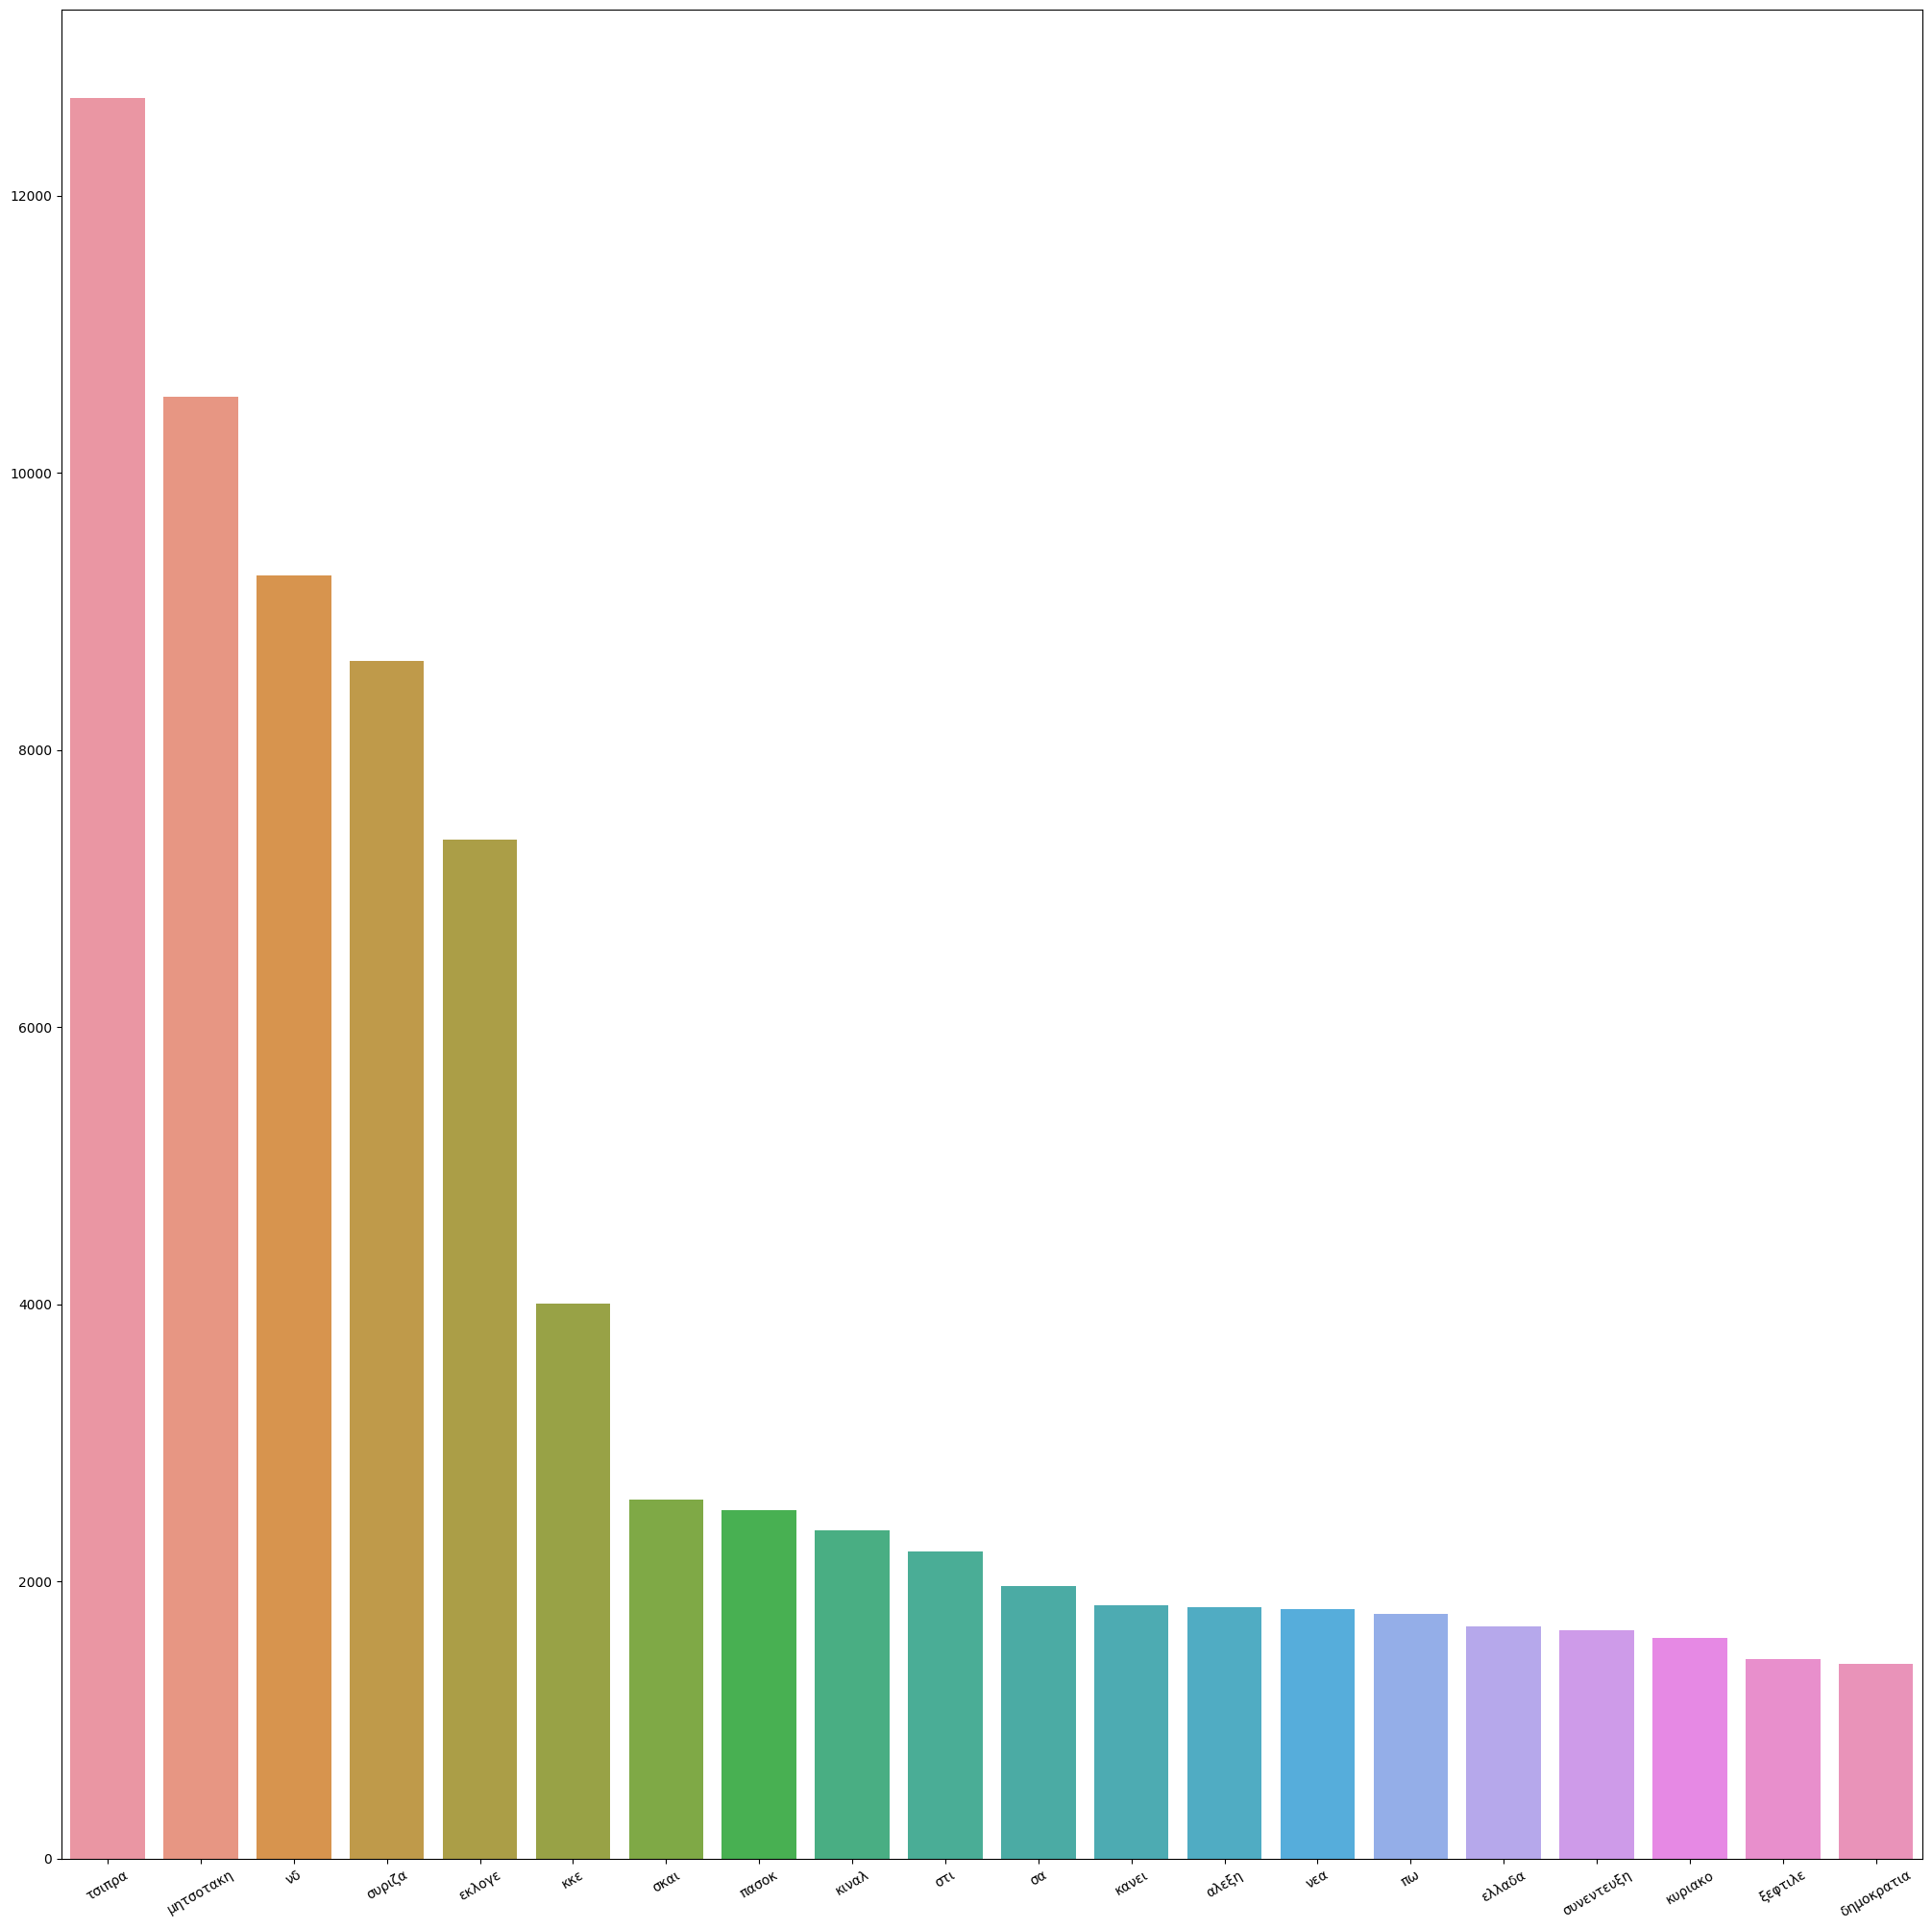

In [6]:
#Data Cleaning
Processor = DataPreprocessing()
params = {'remove_emojis' : 'y'}
original_df['Text'] = Processor.fit_transform(original_df['Text'],**params)
#Analysing words' frequency and statistics
words = nltk.tokenize.word_tokenize(original_df['Text'].str.cat(sep=' '))
word_dist = nltk.FreqDist(words)
most_common = pd.Series(dict(word_dist.most_common(20)))
fig, ax = plt.subplots(figsize=(25,25))
all_plot = sns.barplot(x=most_common.index, y=most_common.values, ax=ax)
plt.xticks(rotation=30)

Vectorization:

In [7]:
#Drop rows from database where column has been left empty
final_df = original_df.dropna(axis=0, how='any')

#Word Embeddings Using Word2Vec
final_df['Text'] = final_df['Text'].apply(lambda x: word_tokenize(x))

# Train Word2Vec model
cores = multiprocessing.cpu_count() # Utilize all the computer's cores
model = Word2Vec(final_df['Text'], 
                 vector_size=210, 
                 window=10, 
                 min_count=1, 
                 workers=cores-1)

final_df['Text'] = final_df['Text'].apply(lambda x: avg_w2v_vector(model.wv,x))
labels_to_int = {"POSITIVE" : 0, "NEGATIVE" : 1 , "NEUTRAL" : 2}
int_to_labels = {0 : "POSITIVE", 1 : "NEGATIVE", 2 : "NEUTRAL"}
labels = labels.apply(lambda x: labels_to_int.get(x))

Creating Sets:

In [8]:
#For consistency in results we use a deterministic way to control the source of random number generator
random.seed(45)
np.random.seed(45)
torch.manual_seed(45)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(45)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = torch.tensor(final_df['Text'], dtype=torch.float, device=device)
Y = torch.tensor(labels, dtype=torch.float, device=device)

#Splitting into Training & Test Set
train_X, remaining_X ,train_Y, remaining_Y = train_test_split(X, Y, test_size=0.2, random_state=28)
val_X, test_X , val_Y, test_Y = train_test_split(remaining_X, remaining_Y, test_size=0.5, random_state=28)

train_set = torch.utils.data.TensorDataset(train_X, train_Y)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32 ,shuffle=True)
val_set = torch.utils.data.TensorDataset(val_X, val_Y)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = val_X.shape[0] ,shuffle=True)
test_set = torch.utils.data.TensorDataset(test_X, test_Y)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = test_X.shape[0] ,shuffle=True)

Deep Neural Network :

In [10]:
class DNN(nn.Module):
  def __init__(self, drop, activation):
    super(DNN, self).__init__()
        
    self.input_layer = nn.Linear(210,90)
    self.hidden_1 = nn.Linear(90,30)
    self.hidden_2 = nn.Linear(30,10)
    self.output = nn.Linear(10,3)
    self.activation = activation()
    self.dropout = nn.Dropout(drop)
    self.final = nn.Softmax(dim=1)
    
  def forward(self, x):
    x = self.activation(self.input_layer(x))
    x = self.dropout(x)
    x = self.activation(self.hidden_1(x))
    x = self.dropout(x)
    x = self.output(self.hidden_2(x))
    x = self.dropout(x)
    return self.final(x)

Training and assessing the model's parameters on each epoch on the validation set to keep the one with the best f1-score and the best epoch (avoiding overfitting)

In [11]:
def evaluation(loader, loss_func, neural):
    neural.eval()
    total_error = 0
    total_correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, (X, label) in enumerate(loader):
            X = X.to(device)
            label = label.to(device).type(torch.LongTensor)
            pred = neural(X)
            total_correct += (pred.argmax(1) == label).type(torch.LongTensor).sum().item()
            total_error += loss_func(pred, label).item()

            # Accumulate predictions and labels for computing metrics after all batches
            all_preds.extend(pred.argmax(1).cpu().tolist())
            all_labels.extend(label.cpu().tolist())

    avg_error = total_error / len(loader.dataset)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    accuracy = total_correct / len(loader.dataset) * 100
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return avg_error , f1_macro , accuracy , conf_matrix ,all_preds

In [12]:
#We do validation in every single epoch so it has to be combined in the training function to evaluate the efficiency of current parameters
def train_and_val(epochs,optimizer,train_loader,val_loader,loss_func,neural,patience) :

  neural.train()
  best_score = -1
  continuous = 0
  #Iterate through batches for every epoch
  for epoch in range(epochs) :
    #iterating through batches
    for i , (X,label) in enumerate(train_loader) :
      # set to zero the parameter gradients
      optimizer.zero_grad()
      # computing loss
      #input data and neural network must be in the same device
      X = X.to(device)
      label = label.type(torch.LongTensor).to(device)
      pred = neural(X)
      error = loss_func(pred,label)
      # computing gradients/the direction that fits our objective
      error.backward()
      #optimizing weights/slightly adjusting parameters
      optimizer.step()
    #compute validation scores for each epoch
    loss , f1 , acc , cf_matr  , preds = evaluation(val_loader,loss_func,neural)

    if acc > best_score :
      wanted = neural
      best_score = acc
      best_epoch = epoch
    else :
      continuous += 1
      if continuous == patience :
          return wanted,best_epoch
        
  return wanted,best_epoch

Experiments:

In [13]:
import logging

# Set the logging level to CRITICAL to deactivate messages
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

def objective(trial):
    # Define the search space for hyperparameters
    epoch = trial.suggest_categorical('epochs', [30, 60])
    func = trial.suggest_categorical('activation_function', [nn.ReLU, nn.Tanh, nn.LeakyReLU, nn.CELU, nn.Hardshrink])
    drop = trial.suggest_categorical('dropout_rate', [0.5, 0.6, 0.7, 0.8])
    opt = trial.suggest_categorical('optimizer', ["SGD", "Adam", "Adagrad", "Adadelta", "Adamax"])
    rate = trial.suggest_categorical('learning_rate', [0.0001,0.001, 0.01, 0.1])
    patience = trial.suggest_categorical('patience', [5, 10,15])

    dnn = DNN(drop, func).to(device)
    optimizer = getattr(torch.optim, opt)(dnn.parameters(), lr=rate)
    loss_func = nn.CrossEntropyLoss()
    best_model,best_epoch = train_and_val(epoch, optimizer, train_loader, val_loader, loss_func, dnn,patience)
    loss, f1, acc, cf_matr , preds = evaluation(test_loader, loss_func, best_model)

    return acc  # The accuracy is the metric to be maximized

Best Parameters for the Model:

In [14]:
study = optuna.create_study(direction='maximize')  # maximize accuracy
study.optimize(objective, n_trials=350)# Run optimization for 350 trials

In [15]:
# Print the best hyperparameters and their corresponding accuracy
best_parameters = study.best_params
print("Best parameters ",best_parameters)

epochs = best_parameters['epochs']
patience = best_parameters['patience']
dnn = DNN(best_parameters['dropout_rate'],best_parameters['activation_function']).to(device)
optimizer = getattr(torch.optim, best_parameters['optimizer'])(dnn.parameters(), lr=best_parameters['learning_rate'])
loss_func = nn.CrossEntropyLoss()
best_model,best_epoch = train_and_val(epochs,optimizer,train_loader,val_loader,loss_func,dnn,patience)
print("Best epoch is : ",best_epoch)
loss , f1 , best_accuracy , cf_matr , preds = evaluation(test_loader,loss_func,best_model)
print("Best f1-score is : ",f1*100 ,"best accuracy is ", best_accuracy)

Best parameters  {'epochs': 30, 'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.6, 'optimizer': 'Adam', 'learning_rate': 0.0001, 'patience': 15}
Best epoch is :  14
Best f1-score is :  38.14906757437173 best accuracy is  39.479340816813945


Test Training with schedulers:

In [16]:
#We do validation in every single epoch so it has to be combined in the training function to evaluate the efficiency of current parameters
def train_with_sched(epochs,optimizer,train_loader,val_loader,loss_func,neural,patience,scheduler) :

  neural.train()
  best_score = -1
  continuous = 0
  #Iterate through batches for every epoch
  for epoch in range(epochs) :
    #iterating through batches
    for i , (X,label) in enumerate(train_loader) :
      # set to zero the parameter gradients
      optimizer.zero_grad()
      # computing loss
      #input data and neural network must be in the same device
      X = X.to(device)
      label = label.type(torch.LongTensor).to(device)
      pred = neural(X)
      error = loss_func(pred,label)
      # computing gradients/the direction that fits our objective
      error.backward()
      #optimizing weights/slightly adjusting parameters
      optimizer.step()
    #compute validation scores for each epoch
    loss , f1 , acc , cf_matr  , preds = evaluation(val_loader,loss_func,neural)
    if scheduler != None :
        scheduler.step()

    if acc > best_score :
      wanted = neural
      best_score = acc
      best_epoch = epoch
    else :
      continuous += 1
      if continuous == patience :
          return wanted,best_epoch
        
  return wanted,best_epoch

In [17]:
def test_sched(epochs,optimizer,train_loader,val_loader,test_loader,best_accuracy,best_sched,loss_func,neural,patience,scheduler) :

    best_model,best_epoch = train_with_sched(epochs,optimizer,train_loader,val_loader,loss_func,neural,patience,scheduler)
    loss , f1 , acc , cf_matr , preds = evaluation(test_loader,loss_func,best_model)
    if(acc > best_accuracy) :
        return acc,scheduler
    return best_accuracy,best_sched

In [18]:
from torch.optim import lr_scheduler

best_sched = None
step_sched = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
exp_sched = lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

#Check schedulers'effect on accuracy
best_accuracy,best_sched = test_sched(epochs,optimizer,train_loader,val_loader,test_loader,best_accuracy,best_sched,loss_func,dnn,patience,step_sched)
best_accuracy,best_sched = test_sched(epochs,optimizer,train_loader,val_loader,test_loader,best_accuracy,best_sched,loss_func,dnn,patience,exp_sched)
print("Best Accuracy is",best_accuracy,"with scheduler :",best_sched)

Best Accuracy is 39.479340816813945 with scheduler : None


Confusion Matrix for Best Model:

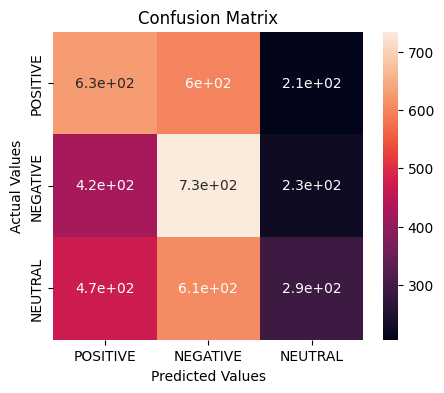

In [19]:
cm_df = pd.DataFrame(cf_matr,
                     index = acceptable_labels, 
                     columns = acceptable_labels)
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

Training & Validation Accuracy Curve:

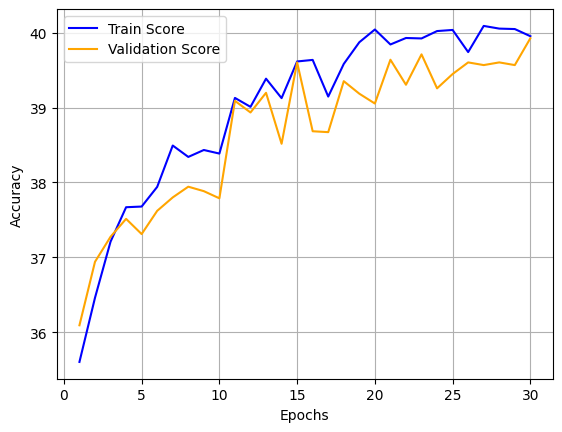

In [20]:
#Plotting Learning Curve
X = torch.tensor(final_df['Text'], dtype=torch.float, device=device)
Y = torch.tensor(labels, dtype=torch.float, device=device)

#Splitting into training (80%) & Validation (20%) Set Only
train_X, val_X ,train_Y, val_Y = train_test_split(X, Y, test_size=0.2, random_state=28)
train_set = torch.utils.data.TensorDataset(train_X, train_Y)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32 ,shuffle=True)   
val_set = torch.utils.data.TensorDataset(val_X, val_Y)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = val_X.shape[0] ,shuffle=True)

train_scores = []
train_loss = []
val_scores = []
val_loss = []

dnn = DNN(best_parameters['dropout_rate'],best_parameters['activation_function']).to(device)
optimizer = getattr(torch.optim, best_parameters['optimizer'])(dnn.parameters(), lr=best_parameters['learning_rate'])
dnn.train()

#Iterate through batches for every epoch
for epoch in range(epochs) :
    #iterating through batches
    for i , (X,label) in enumerate(train_loader) :
        # set to zero the parameter gradients
        optimizer.zero_grad()
        # computing loss
        #input data and neural network must be in the same device
        X = X.to(device)
        label = label.type(torch.LongTensor).to(device)
        pred = dnn(X)
        error = loss_func(pred,label)
        # computing gradients/the direction that fits our objective
        error.backward()
        #optimizing weights/slightly adjusting parameters
        optimizer.step()
    #compute validation & training scores for each epoch
    loss , f1 , acc , cf_matr , preds = evaluation(val_loader,loss_func,dnn)
    val_scores += [acc]
    val_loss += [loss]
    loss , f1 , acc , cf_matr , preds = evaluation(train_loader,loss_func,dnn)
    train_scores += [acc]  
    train_loss += [loss]
    if step_sched != None :
        step_sched.step()

epoch_list = range(1, epochs + 1)
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(epoch_list, train_scores, label="Train Score", color='blue')
plt.plot(epoch_list, val_scores, label="Validation Score", color='orange')
plt.legend()
plt.show()

Training & Validation Loss Curve :

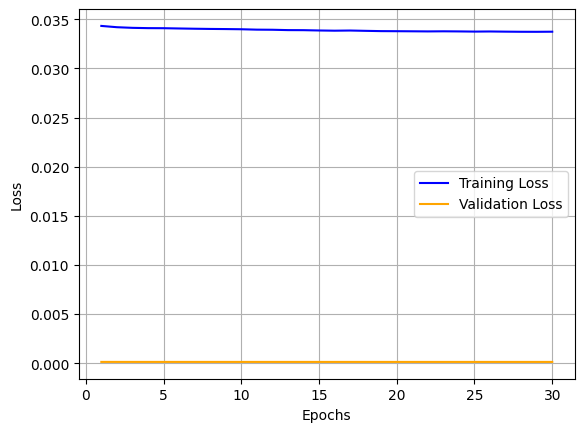

In [21]:
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Epochs')

# Setting colors for the training and validation loss curves
plt.plot(epoch_list, train_loss, label="Training Loss", color='blue')  # Set the color for training loss to blue
plt.plot(epoch_list, val_loss, label="Validation Loss", color='orange')  # Set the color for validation loss to orange

# Show the legend
plt.legend()
plt.show()

In [22]:
def predict(loader, neural):
    neural.eval()
    all_preds = []

    with torch.no_grad():
        for i, (X ) in enumerate(loader):
            X = X.to(device)
            pred = neural(X)
            # Accumulate predictions and labels for computing metrics after all batches
            all_preds.extend(pred.argmax(1).cpu().tolist())

    return all_preds

Implementing best model on actual test set:

In [23]:
#Read Actual Test Set 
test_df = pd.read_csv("/kaggle/input/ys19-2023-assignment-2/test_set.csv")

#Perform best Data Preprocessing Technique 
params = {'remove_emojis' : 'y'}
test_df['Text'] = Processor.fit_transform(test_df['Text'],**params)

#Word Embeddings Using Word2Vec
test_df['Text'] = test_df['Text'].apply(lambda x: word_tokenize(x))
test_df['Text'] = test_df['Text'].apply(lambda x: avg_w2v_vector(model.wv,x))
test_X = torch.tensor(test_df['Text'], dtype=torch.float, device=device)
test_loader = torch.utils.data.DataLoader(test_X, batch_size = test_X.shape[0] ,shuffle=True)

#Train the model in the entire dataset this time
dnn = DNN(best_parameters['dropout_rate'],best_parameters['activation_function']).to(device)
optimizer = getattr(torch.optim, best_parameters['optimizer'])(dnn.parameters(), lr=best_parameters['learning_rate'])
best_model,best_epoch = train_with_sched(epochs,optimizer, train_loader, val_loader, loss_func, dnn,patience,best_sched)
test_pred = predict(test_loader,dnn)

# Create submission.csv output file
with open("submission.csv", "w", newline='') as output_file:
    # Create a CSV writer
    submission = csv.writer(output_file)

    # Write the header row
    submission.writerow(["Id", "Predicted"])

    # Write the data rows
    for idx, predicted_value in zip(test_df['New_ID'], test_pred):
        submission.writerow([idx, int_to_labels[predicted_value]])